In [2]:
import seaborn as sns
from shutil import copyfile
import itertools
import tensorflow as tf
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import cPickle as pickle
import os

sns.set_style("white")
sns.set_palette("husl")

class Config:
    MATCHER = ("^(.*)_(.*)_(.*)_(.*)_(\d+)_(\d*\.?\d*)_(\d*\.?\d*)(_trial\d+)?(_epoch\d+)?")

    def __init__(self, filename):
        groups = self.matches(filename)
        self.strategy = groups[0]
        self.dataset = groups[1]
        self.network = groups[2]
        self.top_k = float(groups[3])
        self.pool_size = int(groups[4])
        self.lr = float(groups[5])
        self.decay = float(groups[6])
        self.trial = None
        self.epoch = None
        if groups[7]:
            unparsed_trial = groups[7]
            self.trial = int(unparsed_trial.strip("_trial"))
        if groups[8]:
            unparsed_epoch = groups[8]
            self.epoch = int(unparsed_epoch.strip("_epoch"))


    def matches(self, filename):
        import re
        return (re.match(Config.MATCHER, filename)).groups()

    @property
    def label(self):
        if self.strategy == "topk":
            label = "{}, {}, top_{}/{}, lr={}".format(self.strategy,
                                                      self.network,
                                                      self.top_k,
                                                      self.pool_size,
                                                      self.lr)
        elif self.strategy == "sampling" or self.strategy == "deterministic":
            label = "{}, {}, {}, {}, lr={}".format(self.strategy,
                                                   self.network,
                                                   self.top_k,
                                                   self.pool_size,
                                                   self.lr)                                               
        if self.trial:
            label += ", trial-{}".format(self.trial)
        if self.epoch:
            label += ", epoch-{}".format(self.epoch)
        return label
    

In [3]:
def print_twitter_examples(sorted_ids):
    print("---------------------------------")
    print("(Rank of 0 is the least backpropped image)")
    twitter_car_front = [1901, 7774, 1196, 2071, 4524, 5558, 1437,
                            5652, 9791, 2652, 3063, 3317]
    twitter_car_back = [1681,2362,8559,8825,3239,9450,1137,6315,9429,7995,
                        8571,1091,4273,7588,9096,9875]
    rankings = [i for i, x in enumerate(sorted_ids) if x in twitter_car_front]
    print("[Twitter Car Front] rankings: {}".format(rankings))
            
    rankings = [i for i, x in enumerate(sorted_ids) if x in twitter_car_back]
    print("[Twitter Car Back] rankings: {}".format(rankings))

In [9]:
def write_images(pickles_dir, plot_dir, src_dir, top_k=50, bottom_k=50, trials=None):
    data_dir = os.path.join(pickles_dir, "pickles/image_id_hist")
    if not os.path.isdir(data_dir): return
    
    for filename in os.listdir(data_dir):
        if "epoch" in filename:
            continue
        config = Config(filename)
        if trials:
            if config.trial not in trials:
                continue

        print("Writing images for {}".format(filename))
        pickles_file = os.path.join(data_dir, filename)
        with open(pickles_file, 'rb') as handle:
            d = pickle.load(handle)
            
            sorted_ids = sorted(d, key=lambda k: d[k])
            
            #print_twitter_examples(sorted_ids)

            subplot_dir = os.path.join(plot_dir, "images_by_frequency")
            top_k_dir = os.path.join(subplot_dir, "least_backpropped")
            bottom_k_dir = os.path.join(subplot_dir, "most_backpropped")
            for directory in [subplot_dir, top_k_dir, bottom_k_dir]:
                if not os.path.isdir(directory):
                    os.mkdir(directory)
                    
            n, bins, patches = plt.hist(d.values(),
                                        50,
                                        normed=0,
                                        facecolor='green',
                                        alpha=0.75)
            print n
                    
            # Write top-k
            print(top_k_dir, bottom_k_dir)
            for image_id in sorted_ids[:top_k]:
                num_backprops = d[image_id]
                src_file = os.path.join(src_dir, "image-{}.png".format(image_id))
                dst_file = os.path.join(top_k_dir, "{}_image-{}.png".format(num_backprops,
                                                                            image_id))
                copyfile(src_file, dst_file)
            
            # Write bottom-k
            for image_id in sorted_ids[-bottom_k:]:
                num_backprops = d[image_id]
                src_file = os.path.join(src_dir, "image-{}.png".format(image_id))
                dst_file = os.path.join(bottom_k_dir, "{}_image-{}.png".format(num_backprops,
                                                                               image_id))
                copyfile(src_file, dst_file)
            




Writing images for deterministic_cifar10_resnet_.1_32_0.001_0.0005_trial1_images_hist.pickle
---------------------------------
(Rank of 0 is the least backpropped image)
[Twitter Car Front] rankings: [58, 119, 146, 167, 392, 695, 18190, 18227, 18300, 27136, 32459, 43578]
[Twitter Car Back] rankings: [90, 807, 10009, 10160, 10556, 11676, 11724, 22991, 29982, 30042, 30054, 36699, 38490, 41365, 42645, 42658]
[1.8014e+04 4.8870e+03 3.6570e+03 2.9970e+03 2.6190e+03 2.3790e+03
 1.9890e+03 3.3100e+03 1.3550e+03 1.2050e+03 1.0660e+03 9.7100e+02
 8.1000e+02 7.0600e+02 1.1580e+03 4.4400e+02 4.1200e+02 3.4700e+02
 3.0700e+02 2.4700e+02 1.9800e+02 3.1100e+02 1.2600e+02 8.8000e+01
 7.3000e+01 7.2000e+01 5.0000e+01 3.5000e+01 6.2000e+01 2.2000e+01
 1.8000e+01 1.5000e+01 1.2000e+01 9.0000e+00 6.0000e+00 5.0000e+00
 4.0000e+00 0.0000e+00 3.0000e+00 1.0000e+00 3.0000e+00 2.0000e+00
 2.0000e+00 2.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00]


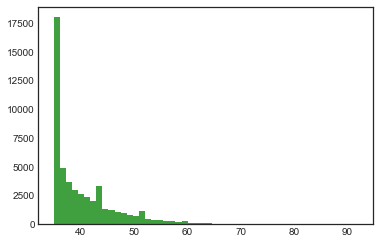

In [198]:
plot_home_dir = "../plots/batch_stats"
src_dir = "../data/images/cifar10_by_id"

experiment_batch_name = "181016_notransform"
plot_home_dir += "/{}".format(experiment_batch_name)

experiment_names = ["181016_notransform_square"]
for experiment_name in experiment_names:
    experiment_dir = "../data/output/cifar10/{}".format(experiment_name)
    plot_dir = "{}/{}".format(plot_home_dir, experiment_name)
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    write_images(experiment_dir, plot_dir, src_dir)

In [192]:
plot_home_dir = "../plots/batch_stats"
src_dir = "../data/images/cifar10_by_id"

experiment_batch_name = "181014_refactor"
plot_home_dir += "/{}".format(experiment_batch_name)

experiment_names = ["181014_square"]
for experiment_name in experiment_names:
    experiment_dir = "../data/output/cifar10/{}".format(experiment_name)
    plot_dir = "{}/{}".format(plot_home_dir, experiment_name)
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    write_images(experiment_dir, plot_dir, src_dir, trials=[1])

Writing images for deterministic_cifar10_resnet_.1_32_0.001_0.0005_trial1_images_hist.pickle
---------------------------------
(Rank of 0 is the least backpropped image)
[Twitter Car Front] rankings: [345, 6638, 6669, 6895, 6947, 7372, 22988, 26521, 28702, 31212, 37120, 40051]
[Twitter Car Back] rankings: [6487, 6596, 6742, 6930, 7968, 14309, 15139, 15142, 28961, 31506, 31587, 33584, 40184, 41354, 46530, 48841]
Writing images for deterministic_cifar10_resnet_.4_32_0.001_0.0005_trial1_images_hist.pickle
---------------------------------
(Rank of 0 is the least backpropped image)
[Twitter Car Front] rankings: [324, 12595, 12671, 12946, 13128, 13243, 15067, 28668, 29305, 29529, 37287, 38232]
[Twitter Car Back] rankings: [654, 747, 12249, 12495, 12806, 13210, 15367, 28595, 29259, 29670, 30137, 30187, 30251, 38204, 42826, 45921]
Writing images for sampling_cifar10_resnet_.1_32_0.001_0.0005_trial1_images_hist.pickle
---------------------------------
(Rank of 0 is the least backpropped image)

Writing images for deterministic_cifar10_resnet_.1_32_0.001_0.0005_trial1_images_hist.pickle
---------------------------------
(Rank of 0 is the least backpropped image)
[Twitter Car Front] rankings: [58, 119, 146, 167, 392, 695, 18190, 18227, 18300, 27136, 32459, 43578]
[Twitter Car Back] rankings: [90, 807, 10009, 10160, 10556, 11676, 11724, 22991, 29982, 30042, 30054, 36699, 38490, 41365, 42645, 42658]
[1.8014e+04 4.8870e+03 3.6570e+03 2.9970e+03 2.6190e+03 2.3790e+03
 1.9890e+03 3.3100e+03 1.3550e+03 1.2050e+03 1.0660e+03 9.7100e+02
 8.1000e+02 7.0600e+02 1.1580e+03 4.4400e+02 4.1200e+02 3.4700e+02
 3.0700e+02 2.4700e+02 1.9800e+02 3.1100e+02 1.2600e+02 8.8000e+01
 7.3000e+01 7.2000e+01 5.0000e+01 3.5000e+01 6.2000e+01 2.2000e+01
 1.8000e+01 1.5000e+01 1.2000e+01 9.0000e+00 6.0000e+00 5.0000e+00
 4.0000e+00 0.0000e+00 3.0000e+00 1.0000e+00 3.0000e+00 2.0000e+00
 2.0000e+00 2.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 1.0000e+00]


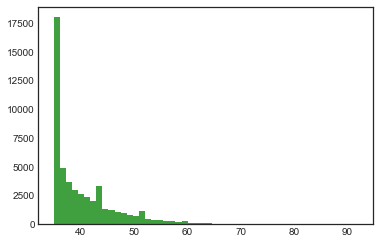

In [199]:
plot_home_dir = "../plots/batch_stats"
src_dir = "../data/images/cifar10_by_id"

experiment_batch_name = "181016_notransform"
plot_home_dir += "/{}".format(experiment_batch_name)

experiment_names = ["181016_notransform_square"]
for experiment_name in experiment_names:
    experiment_dir = "../data/output/cifar10/{}".format(experiment_name)
    plot_dir = "{}/{}".format(plot_home_dir, experiment_name)
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    write_images(experiment_dir, plot_dir, src_dir)

Writing images for sampling_mnist_lecunn_.1_32_0.001_0.0005_trial1_images_hist.pickle
[   40.   455.  2122.  5748. 14679. 10658.  8153.  5316.  3217.  2564.
  1083.   788.   626.   769.   393.   351.   279.   269.   294.   195.
   186.   119.   200.   114.   122.    85.    96.   124.    70.    52.
    69.    99.    59.    58.    47.    47.    60.    42.    29.    39.
    54.    26.    34.    28.    20.    34.    23.    25.    24.    16.]
('../plots/batch_stats/181019_mnist/181019_mnist_square/images_by_frequency/least_backpropped', '../plots/batch_stats/181019_mnist/181019_mnist_square/images_by_frequency/most_backpropped')
Writing images for sampling_mnist_lecunn_.1_32_0.001_0.0005_trial2_images_hist.pickle
[11790.     0.     0.     0.     0.     0.     0. 19441.     0.     0.
     0.     0.     0.     0. 14678.     0.     0.     0.     0.     0.
     0.  7414.     0.     0.     0.     0.     0.     0.  3358.     0.
     0.     0.     0.     0.     0.  1699.     0.     0.     0.     0

[20000.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0. 40000.]
('../plots/batch_stats/181019_mnist/181019_mnist_square/images_by_frequency/least_backpropped', '../plots/batch_stats/181019_mnist/181019_mnist_square/images_by_frequency/most_backpropped')
Writing images for sampling_mnist_lecunn_1_32_0.001_0.0005_trial2_images_hist.pickle
[20000.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
     0.     0.     0.     0.     0.     0.     0.     0.     0. 40000.]
('../plots/ba

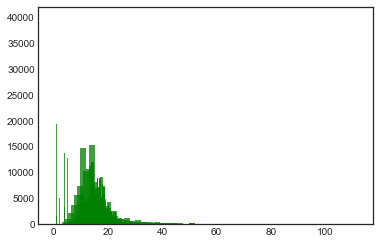

In [10]:
plot_home_dir = "../plots/batch_stats"
src_dir = "../data/images/mnist_by_id"

experiment_batch_name = "181019_mnist"
plot_home_dir += "/{}".format(experiment_batch_name)

experiment_names = ["181019_mnist_square"]
for experiment_name in experiment_names:
    experiment_dir = "../data/output/mnist/{}".format(experiment_name)
    plot_dir = "{}/{}".format(plot_home_dir, experiment_name)
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    write_images(experiment_dir, plot_dir, src_dir)